# Lab 9: Invariant causal prediction

### OOD generalization and the ICP principle

Suppose our goal is to predict $y$ from $x$. Let $p^*(x, y)$ be their ground-truth joint distribution. OOD generalization means that our goal is to estimate a predictor that is useful for prediction when $p^*(x, y)$ shifts to $q^*(x, y)$.

It is commonly said that OOD generalization is impossible without making further assumptions. More precisely, it is impossible to generalize if $p^*(x, y)$ arbitrarily shifts to $q^*(x, y)$, where $q^*(x, y)$ is unrestricted.

Today, we'll discuss an approach to out-of-distribution (OOD) generalization called Invariant Causal Prediction. This idea originated in Peters et al. (2016), and has influenced many follow-up works (Heinze-Deml et al. 2017; Arjovsky et al. 2019; Lu et al. 2022). It's a useful framework for approaching OOD generalization, i.e. restricting the set of possible $q^*(x, y)$'s.

The approach hinges on the simple, yet strong assumption that when the joint distribution shifts, the factor $p^*(y \mid Pa(y))$ remains fixed. Why is this useful? For example, suppose we have a three-variable SCM whose joint distribution factorizes as
\begin{align*}
p^*(x_1, y, x_2) = p^*(x_1) p^*(y \mid x_1) p^*(x_2 \mid y).
\end{align*}
Here, $p^*(y \mid Pa(y)) = p^*(y \mid x_1)$.

The ICP assumption is that when $p^*(x_1, y, x_2)$ shifts to $q^*(x_1, y, x_2)$, we can write $q^*$ as
\begin{align*}
q^*(x_1, y, x_2) &= q^*(x_1) q^*(y \mid x_1) q^*(x_2 \mid y)\\
&= q^*(x_1) p^*(y \mid x_1) q^*(x_2 \mid y).
\end{align*}

Here, the joint distribution shifts because $q^*(x_1) \neq p^*(x_1)$, and $q^*(x_2 \mid y) \neq p^*(x_2 \mid y)$. However, the $p^*(y \mid x_1)$ factor remains invariant by assumption. In order to generalize OOD, we need to estimate $\hat{p}(y \mid x_1)$ to closely approximate $p^*(y \mid x_1)$. Under the ICP assumption, $\hat{p}(y \mid x_1)$ will generalize OOD to samples drawn from $q^*(x_1, y, x_2)$.

Notice that when we estimated $\hat{p}(y \mid x_1)$ using data sampled from $p^*(x_1, y, x_2)$, we only used the $(x_1, y)$ pairs, and ignored $x_2$. This is because we were given the knowledge that $Pa(y) = \{x_1\}$. We typically don't know this in practice, and the most difficult part of applying ICP is identifying $Pa(y)$.

### Turning the ICP principle into an algorithm

Peters et al. (2016) solved this problem in the setting where we observe variables $x_1, \dotsc, x_D, y$, where the data is grouped into **environments**. I.e. instead of observing a single dataset $\{x_1^{(n)}, \dotsc, x_D^{(n)}, y^{(n)}\}_{n=1}^N$, we have $E > 1$ datasets $\{x_1^{e, (n)}, \dotsc, x_D^{e, (n)}, y^{e, (n)}\}_{n=1}^N$ for $e = 1, \dotsc, E$, where $e$ indexes the environment.

Each environment consists of an intervention on a variable in the SCM. Recall that when we intervene, we change the joint distribution. Therefore, if we have a set of $E$ interventions, this results in $E$ different joint distributions. Let's make this concrete for $E = 3$ using the three-variable SCM given by $x_1 \rightarrow y \rightarrow x_2$.

We define $e = 1$ (no intervention) as
\begin{align*}
&x_1 \sim \mathcal{N}(0, 1),\\
&y \sim \mathcal{N}(2x_1, 1),\\
&x_2 \sim \mathcal{N}(3y, 1),
\end{align*}
$e = 2$ (intervention on $x_1$) as
\begin{align*}
&x_1 \sim \mathcal{N}(1, 1),\\
&y \sim \mathcal{N}(2x_1, 1),\\
&x_2 \sim \mathcal{N}(3y, 1),
\end{align*}
and $e = 3$ (intervention on $x_2$) as
\begin{align*}
&x_1 \sim \mathcal{N}(0, 1),\\
&y \sim \mathcal{N}(2x_1, 1),\\
&x_2 \sim \mathcal{N}(-y, 1),
\end{align*}
Notice that $y$ was never intervened on - this is the assumption that ICP hinges on.

Let's generate this data.

In [1]:
import numpy as np
import pandas as pd


rng = np.random.RandomState(0)
n = 1000

# e=1
e1 = {}
e1['x1'] = rng.normal(0, 1, n)
e1['y'] = 2 * e1['x1'] + rng.randn(n)
e1['x2'] = 3 * e1['y'] + rng.randn(n)
e1['e'] = np.ones(n)
e1 = pd.DataFrame(e1)

# e=2
e2 = {}
e2['x1'] = rng.normal(1, 1, n) # Intervention
e2['y'] = 2 * e2['x1'] + rng.randn(n)
e2['x2'] = 3 * e2['y'] + rng.randn(n)
e2['e'] = 2 * np.ones(n)
e2 = pd.DataFrame(e2)

# e=3
e3 = {}
e3['x1'] = rng.normal(0, 1, n)
e3['y'] = 2 * e3['x1'] + rng.randn(n)
e3['x2'] = -1 * e3['y'] + rng.randn(n) # Intervention
e3['e'] = 3 * np.ones(n)
e3 = pd.DataFrame(e3)

# Combined
combined = pd.concat((e1, e2, e3))
print(combined)

           x1         y         x2    e
0    1.764052  4.084067  10.719281  1.0
1    0.400157  1.692788   3.366395  1.0
2    0.978738  1.535161   4.651618  1.0
3    2.240893  4.586500  12.801127  1.0
4    1.867558  3.963169  11.808696  1.0
..        ...       ...        ...  ...
995  1.237818  1.832369  -1.779262  3.0
996  0.289368 -0.250246   0.438413  3.0
997 -1.004584 -2.211902   1.399278  3.0
998 -1.032532 -2.322931   1.241884  3.0
999 -0.901072 -1.731329   2.415445  3.0

[3000 rows x 4 columns]


To identify $Pa(y)$, Peters et al. (2016) fits a linear regression to predict $y$ from each subset of $\{x_1, \dotsc, x_D\}$ using the data from all environments. In our example, the sets of predictors are $\{x_1\}, \{x_2\}$, and $\{x_1, x_2\}$.


Each subset of $\{x_1, \dotsc, x_D\}$ corresponds to a candidate for $Pa(y)$. Then, they look for subsets where the distribution of regression residuals are the same across environments.

Under the ICP assumption, the regression residuals are distributed equally across all environments if we condition on $Pa(y)$, since this blocks the backd

The following function regresses $y$ on $X_S$, where $S$ is the set of predictors, and the computes the residuals for each environment. Let's start with $S = \emptyset$. This model outputs the constant prediction of $\mathbb{E}[y]$.

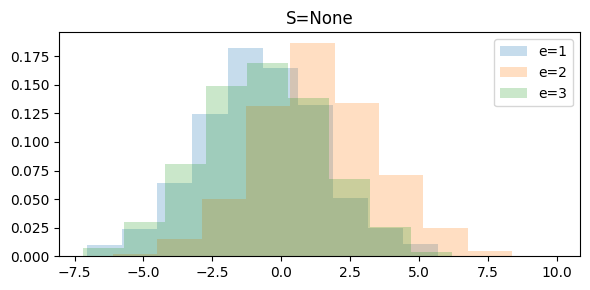

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def get_residuals(combined, predictors):
    if predictors is None:
        x = np.ones((len(combined), 1))
        model = LinearRegression().fit(X=x, y=combined.y)
    else:
        x = combined[predictors]
        model = LinearRegression(fit_intercept=False).fit(X=x, y=combined.y)
    residuals = combined.y - model.predict(x)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.hist(residuals[combined.e == 1], density=True, alpha=0.25, label='e=1')
    ax.hist(residuals[combined.e == 2], density=True, alpha=0.25, label='e=2')
    ax.hist(residuals[combined.e == 3], density=True, alpha=0.25, label='e=3')
    ax.set_title(f'S={predictors}')
    ax.legend()
    fig.tight_layout()
    return residuals

residuals_null = get_residuals(combined, None)

For $S = \emptyset$, the distribution of residuals is clearly different across the three environments by visual inspection. To make this quantitative, we use the two-sample t-test to test the null hypothesis that the residuals have equal mean for $e = 1$ vs. $e \neq 1$, as well as $e = 2$ vs. $e \neq 2$, and $e = 3$ vs. $e \neq 3$.

In [3]:
from scipy.stats import ttest_ind

def get_pvalues(combined, residuals):
    e_range = np.unique(combined.e)
    pvalues = []
    for e in e_range:
        _, pvalue = ttest_ind(residuals[combined.e == e], residuals[combined.e != e])
        pvalues.append(pvalue)
    return pvalues

print(get_pvalues(combined, residuals_null))

[8.073512731060411e-31, 2.456935853415816e-112, 8.883477370253177e-25]


We finally apply the Bonferroni correction to adjust the $p$-values of the three tests, since running multiple tests increases the probability of randomly observing a rare event, and thus falsely rejecting the null hypothesis. If we want to test at the $0.05$ significance level and we run three tests, we reject the null hypothesis for each test if its $p$-value is below $0.05 / 3 = 0.017$.

Since all three $p$-values are below 0.017, we reject the null hypothesis that the residual means have equal mean across environments. Since the residuals are distributed differently, we conclude that $S = \emptyset$ is not a candidate for $Pa(y)$.

Next, we do the same for $S = \{x_1\}$.

[0.6988539303883172, 0.33046991894125777, 0.1737780494629626]


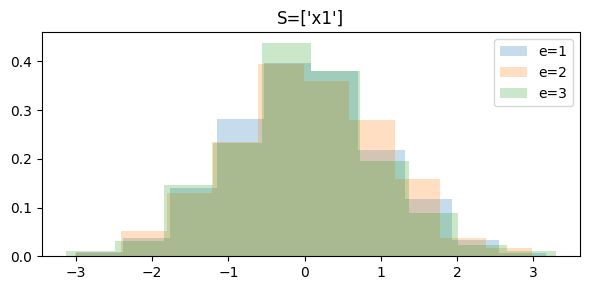

In [4]:
residuals_x1 = get_residuals(combined, ['x1'])
print(get_pvalues(combined, residuals_x1))

In the case of $S = \{x_1\}$, the residuals appear to be distributed equally by visual inspection. The $p$-values are all above $0.017$, so we fail to reject the null hypothesis that their means are equal across environments. Therefore, $S = \{x_1\}$ is included as a candidate for $Pa(y)$, which is the correct conclusion given the ground-truth causal graph.

Here are the results for $S = \{x_2\}$.

[0.005446319619253305, 1.4458461312957684e-07, 0.013477894366100087]


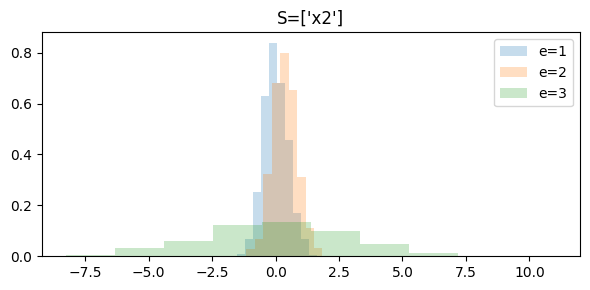

In [5]:
residuals_x2 = get_residuals(combined, ['x2'])
print(get_pvalues(combined, residuals_x2))

Since the $p$-values are all below $0.017$, we reject $S$ as a candidate for $Pa(y)$.

Finally, here are the results for $S = \{x_1, x_2\}$.

[0.01452068993016438, 0.002216507408307851, 0.5390121986306311]


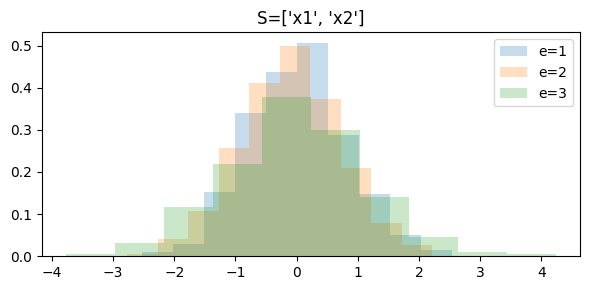

In [6]:
residuals_x1x2 = get_residuals(combined, ['x1', 'x2'])
print(get_pvalues(combined, residuals_x1x2))

Since at least one of the $p$-values is below $0.017$, we reject the null hypothesis of equal means, and therefore $S = \{x_1, x_2\}$ is not a candidate for $Pa(y)$.

The final prediction for $Pa(y)$ is $\{x_1\}$, which is correct.

In [7]:
import os
import requests

def download_from_url(url, filename, overwrite=False):
    if os.path.exists(filename) and not overwrite:
        return
        
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

### Causal representation learning

Peters et al. (2016) is a seminal work in this area, but it doesn't apply when $x_1, \dotsc, x_D$ represents e.g. the pixels of an image. There are two main reasons for this. The first is for the practical reason that when $D$ is large (e.g. for X-rays, $D > 10^7$), the number of subsets of $\{x_1, \dotsc, x_D\}$ becomes prohibitively large.

The second, and more important reason, is that it doesn't make sense to assume that $y$ is generated by a function of some fixed subset of $x_1, \dotsc, x_D$. This is because each pixel doesn't have a semantic meaning. Instead, there are some objects with semantic meaning, and they are collectively represented by all of the pixels.

This brings us to the nascent field of causal representation learning. The goal of causal representation learning is to take low-level observations such as images, and (i) learn what the high-level causal variables are, and (ii) the causal graph that relates them.

Taking bird classification as an example, the input $x_1, \dotsc, x_D$ are the pixels of the image of a bird, and the target $y$ is the bird species. In step (i), we learn the high-level causal variables, such as the beak and wingspan. In step (ii), we learn the relationships between these causal variables. E.g. seabirds such as albatross tend to have a long wing-span and straight beak, so beak and wingspan are correlated.

Let's look at some benchmark datasets and think about whether the ICP principle is sensible.

### Example datasets

#### PACS

Photos, art paintings, cartoons, sketches (PACS) (Li et al., 2017) is a very popular dataset for this problem. It is an image classification dataset, where the goal is to classify whether the object in the image is a dog, horse, house, etc (seven categories). There are four environments: photos, art paintings, cartoons, and sketches. The goal is to learn a classifier using three training environments, and generalize OOD to the held-out test environment.

What does it mean to adopt the ICP assumption in this context? It means that each object can be distinguished using a set of high-level causal variables that exist across all environments.

It's helpful to first think about what features wouldn't satisfy this. E.g. suppose that horses in photos and paintings appear in grassy fields, and no other objects do. Then, we can use the presence of a grassy field to accurately predict horses in photos and paintings. However, this prediction rule wouldn't work on cartoons or sketches.

In contrast, the outline of the shape of a horse can be detected in all environments. Therefore, we should learn this feature from the image, and call it $Pa(y)$.

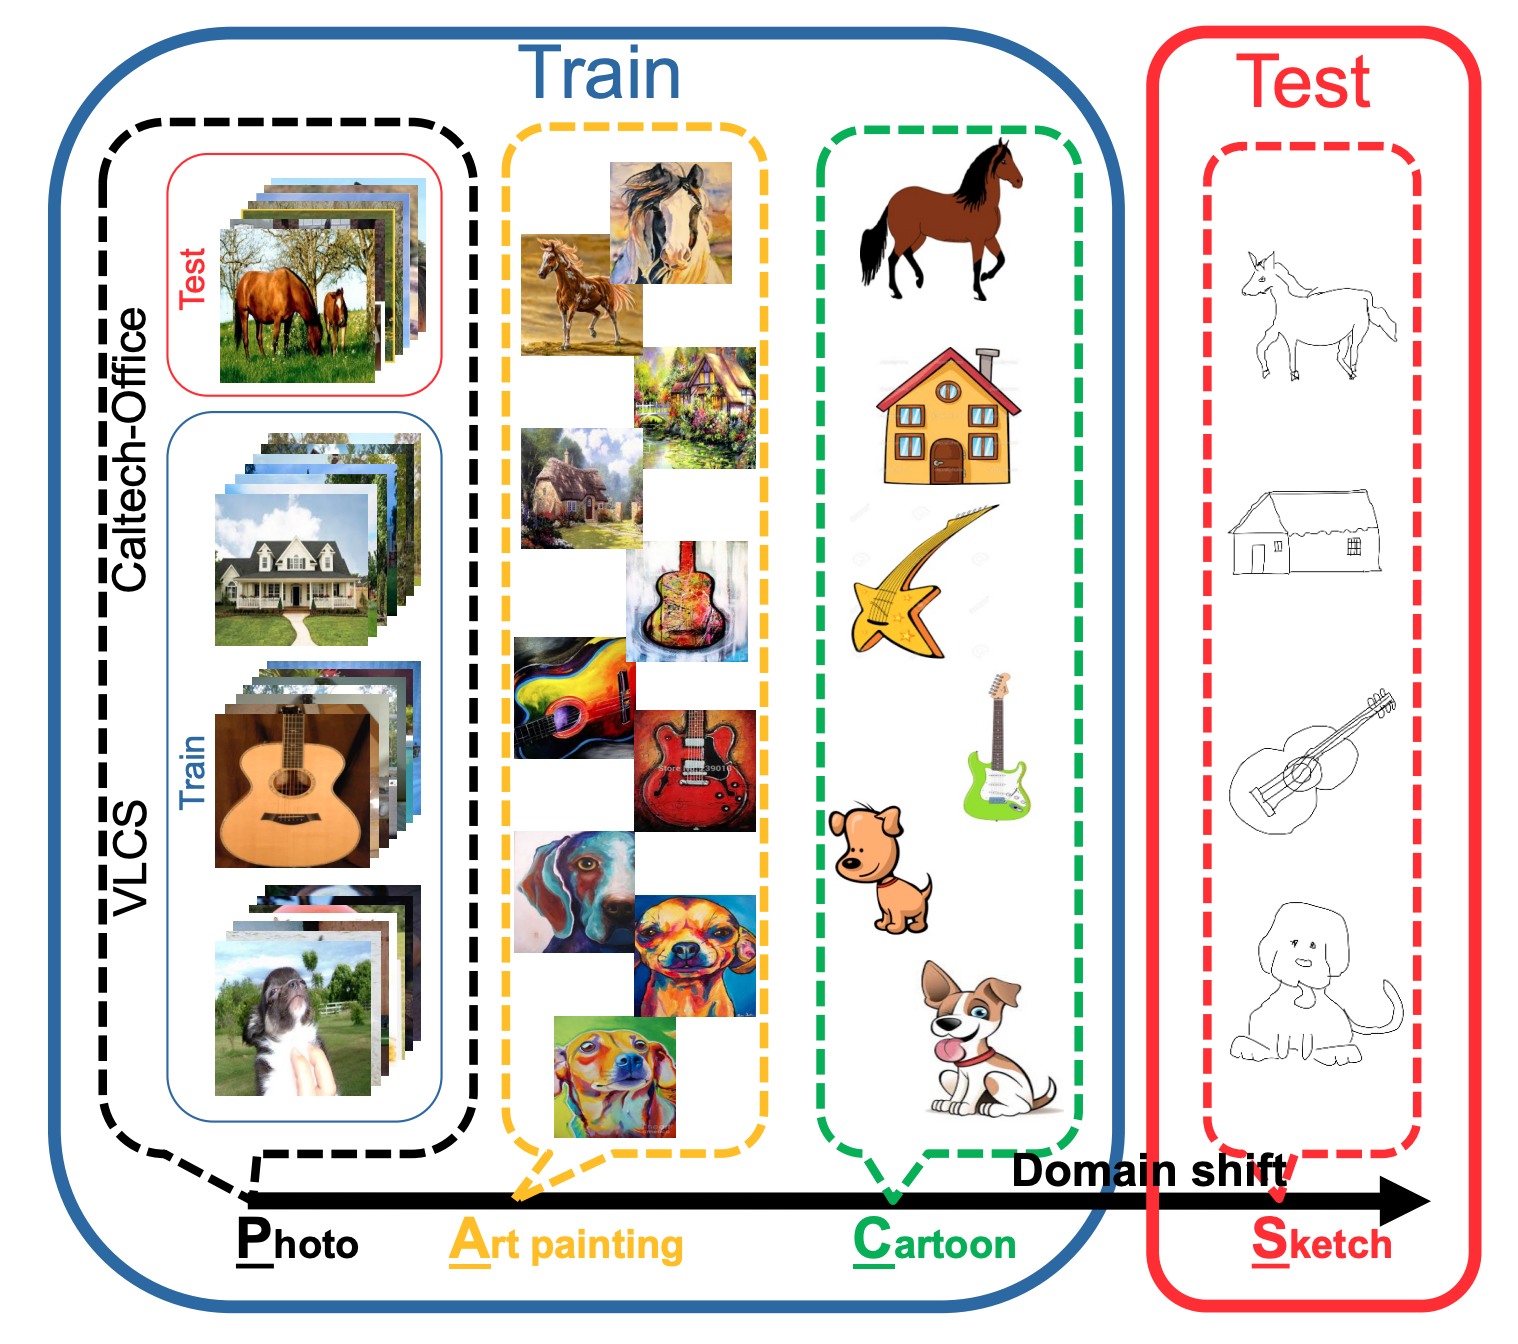

In [8]:
from IPython.display import Image
download_from_url('https://nyu.box.com/shared/static/s5pl0gc8p9pybe2o1bi8ypl2fny5xrvy.png', 'pacs.png')
Image('pacs.png', width=512)

#### Camelyon17

Next, let's consider the Camelyon17 dataset (Koh et al., 2021). This is a medical image classification dataset, where the images are histopathology images, and $y$ is a binary target representing the presence of breast cancer. The multiple environments correspond to different hospitals. There is variation in the images across hospitals, mainly due to differences in staining (color).

What is the ICP principle here? Again, let's start by thinking about what wouldn't work. Hypothetically, suppose that some hospital has a higher prevalence of cancer among its patients. Then, it would be beneficial to use the color of the image to determine which hospital it came from. However, this prediction rule would not work on images from an unseen hospital, i.e. it would not generalize OOD. Instead, we should let $Pa(y)$ represent the biomarkers of disease, which is predictive across all hospitals.

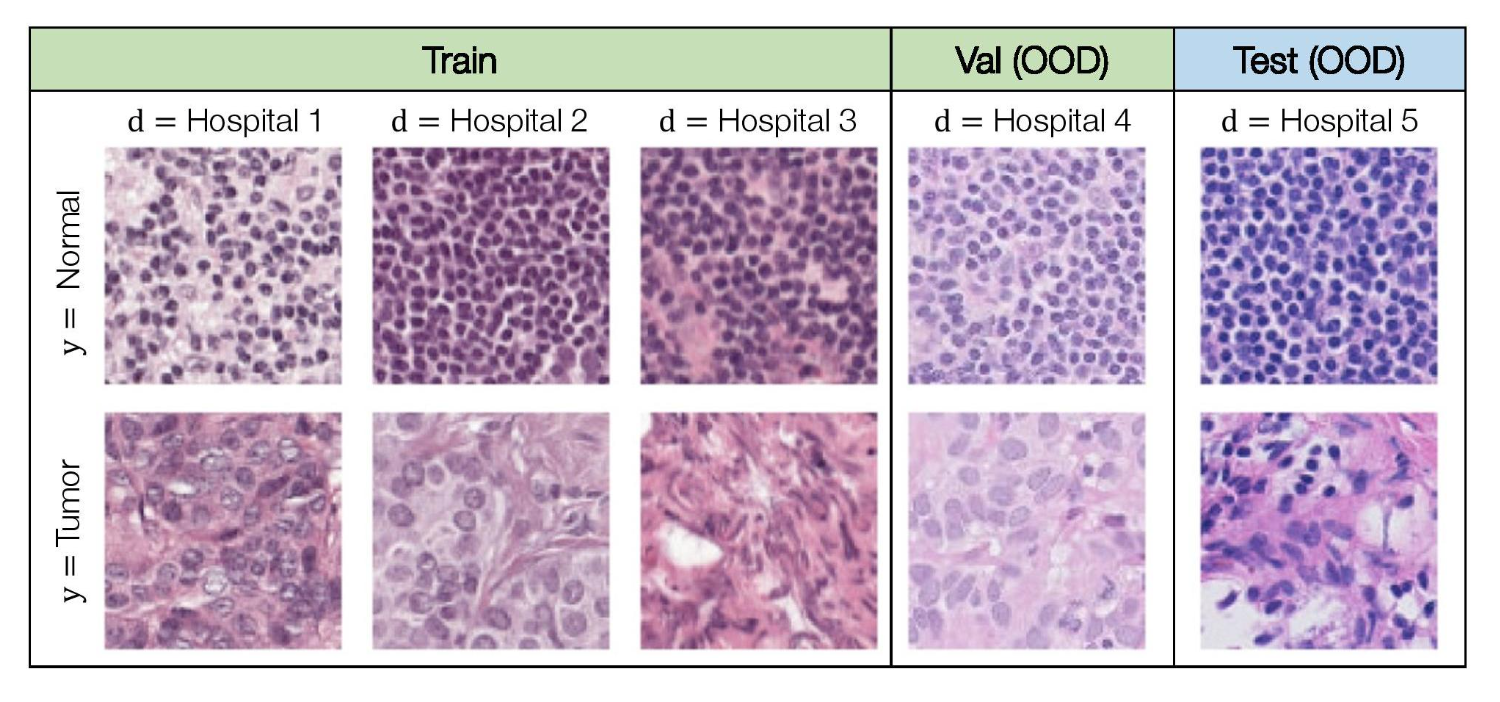

In [9]:
download_from_url('https://nyu.box.com/shared/static/ksfp9ds2e3y5pn2dx7ciw78apdur29zr.png', 'camelyon17.png')
Image('camelyon17.png', width=512)